# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

### 🚨 WARNING
The notebook will run throughout, but will only produce tables if all simulations have been run and are stored in the `output`folder.

_Note_: a `figures` folder will be created in which the tables are saved.

Simulations can be run using the following command:
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --aug-strategy-train augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10

```

📝 Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

### Goal

The aim of this notebook is to compare the results on the test set for
- all tasks (ESOL, free solv, and lipophilicity),
- all models (CONV1D, CONV2D and RNN),
- all augmentation strategies: no augmentation, augmentation with-, without-, with reduced duplication, and estimated maximum,

and analyse the results.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from IPython.display import display
import dataframe_image as dfi
from maxsmi.utils_analysis import retrieve_metric

In [2]:
# Make a folder for output figures
os.makedirs("figures", exist_ok=True)

## Dataset
We consider the following datasets:

- ESOL
- free_solv
- lipophilicity

Comment/uncomment the dataset of choice in the cell below.

In [3]:
# TASK = "lipophilicity"
# TASK = "ESOL"
TASK = "free_solv"

### Grid: augmentation number

The models were run of a fine grid augmentation: from 1 to 20 with a step of 1 as well as a coarser grid: from 20 to 100 with a step of 10.

In [4]:
fine_grid = [elem for elem in range(0, 21, 1)]
coarse_grid = [elem for elem in range(10, 110, 10)]

temp_grid = [elem for elem in range(30, 110, 10)]
full_grid = fine_grid + temp_grid

In [5]:
def array_by_strategy(augmentation_strategy,
                      task="ESOL",
                      set_="test",
                      metric="rmse",
                      grid=full_grid):
    """

    Returns an array of a given metric for a given task.

    Parameters
    ----------
    augmentation_strategy : str
        The augmentation strategy to consider,
        e.g. `augmentation_with_reduced_duplication`.
    task : str, default `ESOL`
        The dataset to consider: ESOL, free_solv or lipophilicity.
    set_ : str, default `test`
        The evaluation set, train or test.
    metric: str, default `rmse`
        The performance metric to consider,
        such as the root mean squared error (rmse).
    grid: list
        The augmentation number to retrieve.

    Returns
    -------
    np.array
        Numeric values for `metric`.
    """

    models = ["CONV1D", "CONV2D", "RNN"]

    result_array = np.zeros((len(grid), len(models)))

    if augmentation_strategy == "augmentation_maximum_estimation":
        if task == "ESOL":
            task = "ESOL_SMALL"
            # Estimated maximum strategy was only evaluated
            # on a subset of ESOL, because time-intensive purposes.

    for i, model in enumerate(models):
        for j, augmentation_num in enumerate(grid):
            try:
                y = retrieve_metric(
                    metric,
                    set_,
                    task,
                    augmentation_strategy,
                    augmentation_num,
                    augmentation_strategy,
                    augmentation_num,
                    model,
                )
            except FileNotFoundError:
                y = np.nan
            result_array[j, i] = y
    return result_array

## Retrieve performance by augmentation strategy

In [6]:
results_without_dupl = array_by_strategy("augmentation_without_duplication",
                                         task=TASK)
results_with_dupl = array_by_strategy("augmentation_with_duplication",
                                      task=TASK)
results_with_red_dupl = array_by_strategy("augmentation_with_reduced_\
duplication",
                                          task=TASK)
results_max_est = array_by_strategy("augmentation_maximum_estimation",
                                    task=TASK)
results_no_aug = array_by_strategy("no_augmentation",
                                   task=TASK)

_Note:_

The augmentation strategy `estimated maximum` was not evaluated on the lipohilicity dataset.

In [7]:
if TASK == "lipophilicity":
    full_results = np.concatenate([results_without_dupl,
                                   results_with_dupl,
                                   results_with_red_dupl,
                                   results_no_aug], axis=1)
    column_name = [
        ('with duplication', 'CONV1D'),
        ('with duplication', 'CONV2D'),
        ('with duplication', 'RNN'),
        ('without duplication', 'CONV1D'),
        ('without duplication', 'CONV2D'),
        ('without duplication', 'RNN'),
        ('with reduced duplication', 'CONV1D'),
        ('with reduced duplication', 'CONV2D'),
        ('with reduced duplication', 'RNN'),
        ('no augmentation', 'CONV1D'),
        ('no augmentation', 'CONV2D'),
        ('no augmentation', 'RNN'),
    ]

else:
    column_name = [
        ('with duplication', 'CONV1D'),
        ('with duplication', 'CONV2D'),
        ('with duplication', 'RNN'),
        ('without duplication', 'CONV1D'),
        ('without duplication', 'CONV2D'),
        ('without duplication', 'RNN'),
        ('with reduced duplication', 'CONV1D'),
        ('with reduced duplication', 'CONV2D'),
        ('with reduced duplication', 'RNN'),
        ('no augmentation', 'CONV1D'),
        ('no augmentation', 'CONV2D'),
        ('no augmentation', 'RNN'),
        ('estimated maximum', 'CONV1D'),
        ('estimated maximum', 'CONV2D'),
        ('estimated maximum', 'RNN'),
    ]
    full_results = np.concatenate([results_without_dupl,
                                   results_with_dupl,
                                   results_with_red_dupl,
                                   results_no_aug,
                                   results_max_est], axis=1)

## Table

Generate the pandas dataframe of the results, with multicolumns.

In [8]:
dataframe = pd.DataFrame(full_results,
                         columns=column_name,
                         index=full_grid)

In [9]:
dataframe.columns = pd.MultiIndex.from_tuples(dataframe.columns,
                                              names=['Strategy', 'Model'])
dataframe

Strategy with duplication                     without duplication            \
Model              CONV1D    CONV2D       RNN              CONV1D    CONV2D   
0                     NaN       NaN       NaN                 NaN       NaN   
1                2.576553  2.867690  2.513789            2.603028  2.881221   
2                2.107822  2.222457  1.989296            2.021471  2.102961   
3                1.914096  2.315347  1.900420            1.955804  1.966772   
4                1.494451  1.646310  1.545067            1.444198  1.692500   
5                1.260051  1.524381  1.380570            1.341978  1.516899   
6                1.306289  1.580351  1.397609            1.277238  1.722576   
7                1.415770  2.004465  1.611623            1.364584  1.492614   
8                1.257534  1.446213  1.273156            1.281537  1.472069   
9                1.325040  1.578069  1.237859            1.323704  1.598498   
10               1.190051  1.485084  1.303380            1.231074  1.517179   
11               1.224704  1.433660  1.331317            1.195230  1.518891   
12               1.181272  1.392629  1.422093            1.197999  1.438357   
13               1.307932  1.522008  1.391981            1.146017  1.584459   
14               1.161572  1.483182  1.239547            1.196892  1.500683   
15               1.168624  1.516332  1.237257            1.160298  1.545302   
16               1.138419  1.305616  1.256118            1.095630  1.488440   
17               1.146968  1.493314  1.320557            1.161985  2.287752   
18               1.139168  1.503643  1.259671            1.140851  1.493708   
19               1.163891  1.475479  1.244214            1.159093  1.561230   
20               1.139182  1.522832  1.329581            1.084603  1.449123   
30               1.082927  1.374254  1.299155            1.120433  1.552755   
40               1.140160  1.524841  1.311394            1.051448  1.700225   
50               1.091181  1.579425  1.290504            1.053133  1.452142   
60               1.073911  1.553867  1.264451            1.093533  1.427343   
70               1.084567  1.679290  1.239409            1.032067  1.475831   
80               1.125119  1.638817  1.270036            1.069986  1.448608   
90               1.101427  1.506012  1.280484            1.058080  1.555853   
100              1.115065  1.630677  1.276083            1.056276  1.598153   

Strategy           with reduced duplication                      \
Model          RNN                   CONV1D    CONV2D       RNN   
0              NaN                      NaN       NaN       NaN   
1         2.395808                 2.691229  3.017233  2.431184   
2         2.122376                 2.090806  1.978924  2.001960   
3         1.809600                 1.916622  2.371182  4.111752   
4         1.479107                 1.420278  1.594135  1.568063   
5         1.332053                 1.278124  1.478080  1.468778   
6         1.351626                 1.305634  1.655896  1.357706   
7         1.445625                 1.415027  1.558877  1.398226   
8         1.288066                 1.237856  1.374845  1.258589   
9         1.240258                 1.286977  1.497929  1.252765   
10        1.290062                 1.211134  1.543577  1.228639   
11        1.224318                 1.238219  1.410347  1.282998   
12        1.273001                 1.196125  1.448572  1.198974   
13        1.326868                 1.199066  1.556534  1.266257   
14        1.278678                 1.149466  1.501389  1.477429   
15        1.202259                 1.188089  1.441458  1.222893   
16        1.156832                 1.101718  1.397177  1.249520   
17        1.231283                 1.116592  1.501469  1.294920   
18        1.569040                 1.098654  1.572073  1.213241   
19        1.530544                 1.128689  1.557709  1.272404   
20        1.273992                 1.108972  1.501850  1.198534   
30       

## Cosmetics

We beautify the dataframe for readibily.

In [10]:
def color_nan_white(val):
    """Color the nan text white"""
    if np.isnan(val):
        return 'color: white'

In [11]:
def color_nan_white_background(val):
    """Color the nan cell background white"""
    if np.isnan(val):
        return 'background-color: white'

In [12]:
df_styler = dataframe.style.\
    set_caption(f"Data: {TASK}").\
    format("{:.3f}").\
    background_gradient(cmap='Purples', axis=None).\
    applymap(lambda x: color_nan_white(x)).\
    applymap(lambda x: color_nan_white_background(x)).\
    highlight_min(color="yellow", axis=None)

df_styler

In [13]:
dfi.export(df_styler, f"figures/dataframe_{TASK}.png")

## Plots

Let's display plots instead of tables.

In [14]:
fine_grid = [elem for elem in range(1, 21, 1)]
coarse_grid = [elem for elem in range(10, 110, 10)]

temp_grid = [elem for elem in range(30, 110, 10)]
full_grid = fine_grid + temp_grid

### Plot for best model

In [15]:
def plot_metric_for_model(metric,
                          set_,
                          augmentation_strategy,
                          task="ESOL",
                          grid=full_grid):
    """
    Plots the metric of interest on the set of interest for a given model.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    augmentation_strategy : str
            The augmentation strategy used.
    task : str
        The task considered.
    grid : list
        The grid to retrieve for aumgentation number.

    Returns
    -------
    None
    """
    models = ["CONV1D", "CONV2D", "RNN"]

    x = [step for step in grid]

    fig, ax = plt.subplots(1, 1)

    for model in models:
        legend_ = []
        y_model = []
        for augmentation_num in grid:
            y = retrieve_metric(
                metric,
                set_,
                task,
                augmentation_strategy,
                augmentation_num,
                augmentation_strategy,
                augmentation_num,
                model,
            )
            y_model.append(y)
        ax.plot(x, y_model)
        ax.set_title(f"Data: {task} \nStrategy: {augmentation_strategy}")
        ax.set_xlabel("Number of augmentation")
        ax.set_xlabel("Number of augmentation")
        if metric == "rmse":
            ax.set_ylabel(f"{set_} RMSE")
        elif metric == "time":
            ax.set_ylabel(f"{set_} {metric} [sec]")
        else:
            ax.set_ylabel(f"{set_}{metric}")
        legend_.append(model)
    ax.legend(models)

    plt.savefig(f"figures/{task}_{model}_for_model.svg",
                dpi=1200,
                facecolor='w',
                edgecolor='w',
                orientation='portrait',
                format="svg",
                transparent=False,
                bbox_inches=None,
                pad_inches=0.1,)

    plt.show()

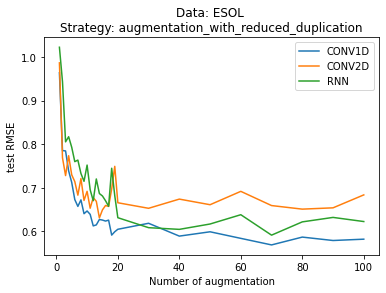

In [16]:
plot_metric_for_model("rmse", "test",
                      "augmentation_with_reduced_duplication",
                      grid=full_grid)

### Plot for best strategy

In [17]:
def plot_metric_for_strategy(metric,
                             set_,
                             task="ESOL",
                             model="CONV1D",
                             grid=full_grid):
    """
    Plots the metric of interest on the set of interest
    for a given model.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    task : str
        The task of interest, e.g. "ESOL".
    model : str
        The model to consider.
    grid : list
        The grid to retrieve for aumgentation number.

    Returns
    -------
    None
    """

    x = [step for step in grid]

    fig, ax = plt.subplots(1, 1)

    for augmentation_strategy in [
        "augmentation_with_duplication",
        "augmentation_without_duplication",
        "augmentation_with_reduced_duplication"
    ]:
        legend_ = []
        y_strategy = []
        for augmentation_num in grid:
            y = retrieve_metric(
                metric,
                set_,
                task,
                augmentation_strategy,
                augmentation_num,
                augmentation_strategy,
                augmentation_num,
                model,
            )
            y_strategy.append(y)
        ax.plot(x, y_strategy)
        if metric == "rmse":
            ax.set_ylabel(f"{set_} RMSE")
        elif metric == "time":
            ax.set_ylabel(f"{set_} {metric} [sec]")
        else:
            ax.set_ylabel(f"{set_} {metric}")
        legend_.append(augmentation_strategy)

    ax.set_title(f"Data: {task}\nModel: {model}")
    ax.set_xlabel("Number of augmentation")

    # Retrieve no augmentation
    y_no_augmentation = retrieve_metric(
        metric,
        set_,
        task,
        "no_augmentation",
        0,
        "no_augmentation",
        0,
        model,
    )
    # Retrieve augmentation with maximum duplication
    if task == "ESOL":
        task = "ESOL_small"
    y_est_max = retrieve_metric(
        metric,
        set_,
        task,
        "augmentation_maximum_estimation",
        10,
        "augmentation_maximum_estimation",
        10,
        model,
    )
    plt.axhline(y=y_est_max, color='r', linestyle='-')
    trans = transforms.blended_transform_factory(
        ax.get_yticklabels()[0].get_transform(),
        ax.transData)
    ax.text(0, y_est_max,
            f"{y_est_max:.3f}",
            transform=trans,
            color='red',
            ha="right",
            va="center")

    plt.axhline(y=y_no_augmentation,
                color='black',
                linewidth=0.7,
                linestyle='dashed')

    ax.legend([
        "augmentation_with_duplication",
        "augmentation_without_duplication",
        "augmentation_with_reduced_duplication",
        "augmentation_with_estimated_maximum",
        "no_augmentation"
        ])
    plt.savefig(f"figures/{task}_{model}_for_strategy.svg",
                dpi=1200,
                facecolor='w',
                edgecolor='w',
                orientation='portrait',
                format="svg",
                transparent=False,
                bbox_inches=None,
                pad_inches=0.1,)

    plt.show()

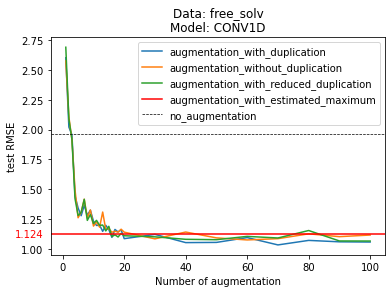

In [18]:
plot_metric_for_strategy("rmse",
                         "test",
                         task="free_solv",
                         model="CONV1D",
                         grid=full_grid)

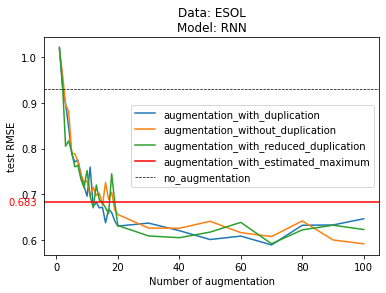

In [19]:
plot_metric_for_strategy("rmse",
                         "test",
                         task="ESOL",
                         model="RNN",
                         grid=full_grid)

### Plot all metrics, all models and all augmentation strategies

In [20]:
def plot_all(metric, set_, grid):
    """
    Plots the metric of interest on the set of interest.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    augmentation_strategy : str
            The augmentation strategy used.
    max_augmentation : int, default is 100.
        The largest number of augmentation that was performed.

    Returns
    -------
    None
    """

    tasks = ["ESOL", "free_solv", "lipophilicity"]
    models = ["CONV1D", "CONV2D", "RNN"]

    x = [step for step in grid]

    fig, ax = plt.subplots(nrows=len(tasks),
                           ncols=len(models),
                           figsize=(20, 20))

    for i, task in enumerate(tasks):
        for j, model in enumerate(models):
            legend_ = []
            for augmentation_strategy in [
                "augmentation_with_duplication",
                "augmentation_without_duplication",
                "augmentation_with_reduced_duplication"
            ]:
                y_task_model_strategy = []
                for augmentation_num in grid:
                    y = retrieve_metric(
                        metric,
                        set_,
                        task,
                        augmentation_strategy,
                        augmentation_num,
                        augmentation_strategy,
                        augmentation_num,
                        model,
                    )
                    y_task_model_strategy.append(y)
                ax[i, j].plot(x, y_task_model_strategy)
                ax[i, j].set_title(f"Data: {task} \nModel: {model}")
                ax[i, j].set_xlabel("Number of augmentation")
                if metric == "rmse":
                    ax[i, j].set_ylabel(f"{set_} RMSE")
                elif metric == "time":
                    ax[i, j].set_ylabel(f"{set_} {metric} [sec]")
                else:
                    ax[i, j].set_ylabel(f"{set_} {metric}")
                caption = f"{augmentation_strategy}"
                legend_.append(caption)
                ax[i, j].legend(legend_)
    plt.savefig(f"figures/all_combinations_{metric}.svg",
            dpi=1200,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format="svg",
            transparent=False,
            bbox_inches=None,
            pad_inches=0.1,)
    plt.show()

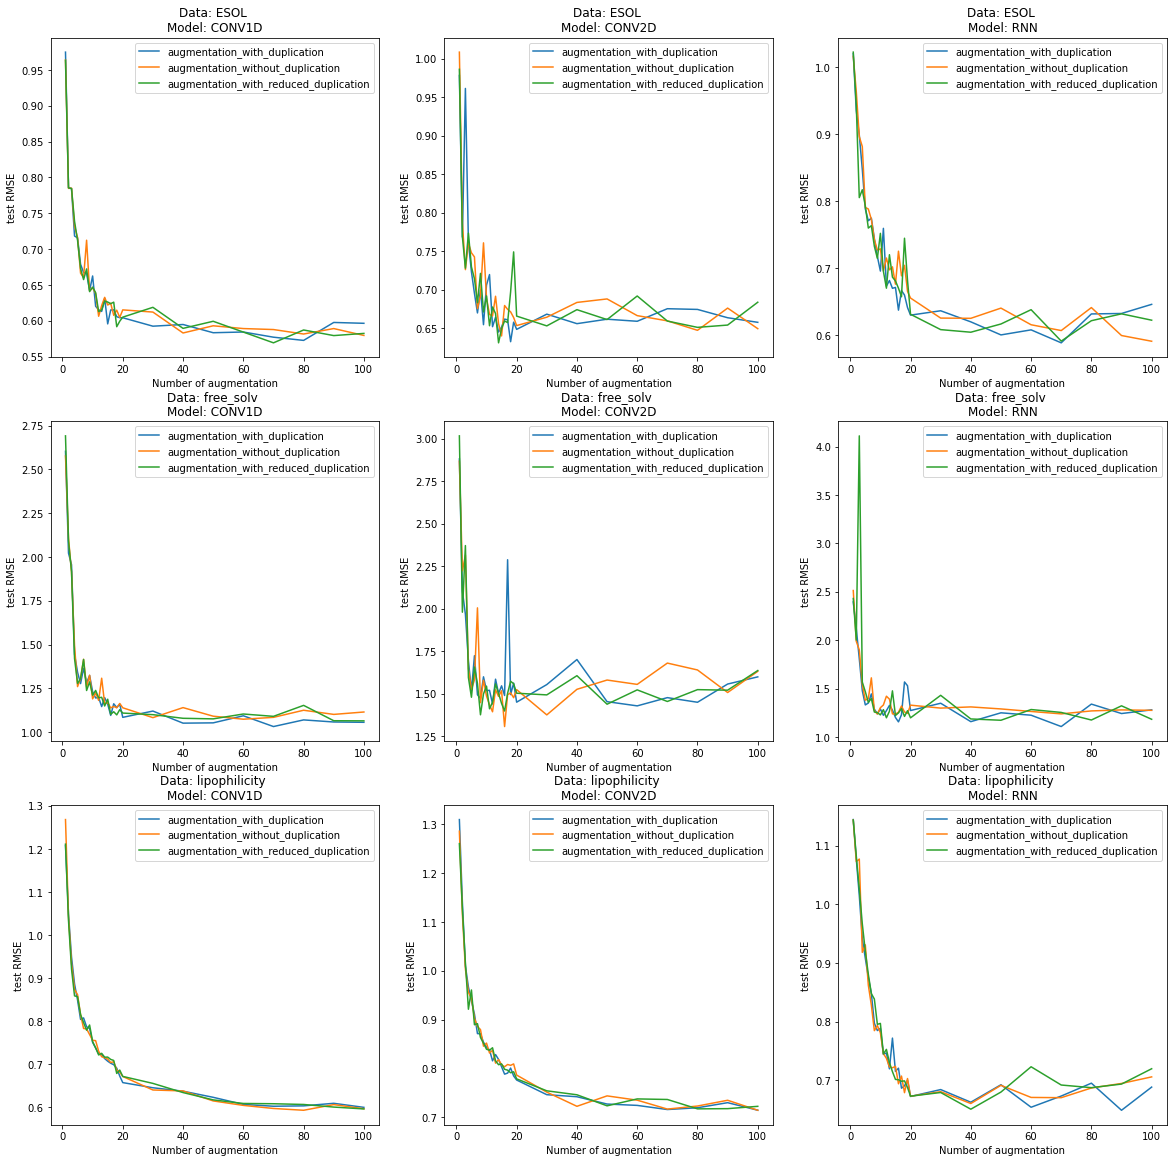

In [21]:
plot_all("rmse", "test", full_grid)

In [22]:
def plot_single(metric, set_, grid, task, model):
    """
    Plots the metric of interest on the set of interest.

    Parameters
    ----------
    metric : str
        The metric of interest, such as the r2 score,
        time or mean squared error.
    set_ : str
        The train set or test set.
    task : str
        The considered task.
    model : str
        The considered model.

    Returns
    -------
    None
    """

    x = [step for step in grid]

    fig, ax = plt.subplots()

    legend_ = []
    for augmentation_strategy in [
        "augmentation_with_duplication",
        "augmentation_without_duplication",
        "augmentation_with_reduced_duplication"
    ]:
        y_task_model_strategy = []
        for augmentation_num in grid:
            y = retrieve_metric(
                metric,
                set_,
                task,
                augmentation_strategy,
                augmentation_num,
                augmentation_strategy,
                augmentation_num,
                model,
            )
            y_task_model_strategy.append(y)
        ax.plot(x, y_task_model_strategy)
        ax.set_title(f"Data: {task} \nModel: {model}")
        ax.set_xlabel("Number of augmentation")
        ax.set_ylabel(f"{metric}")
        if metric == "rmse":
            ax.set_ylabel(f"{set_} RMSE")
        elif metric == "time":
            ax.set_ylabel(f"{set_} {metric} [sec]")
        else:
            ax.set_ylabel(f"{set_} {metric}")
        caption = f"{augmentation_strategy}"
        legend_.append(caption)
        ax.legend(legend_)
    plt.savefig(f"figures/{task}_{metric}_{model}_{set_}_3strategies.svg",
            dpi=1200,
            facecolor='w',
            edgecolor='w',
            orientation='portrait',
            format="svg",
            transparent=False,
            bbox_inches=None,
            pad_inches=0.1,)
    plt.show()

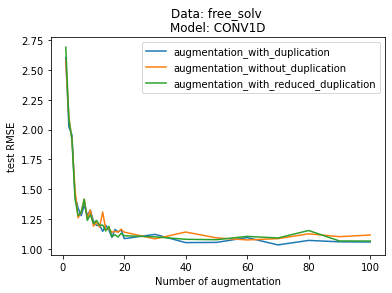

In [23]:
plot_single("rmse", "test", full_grid, "free_solv", "CONV1D")

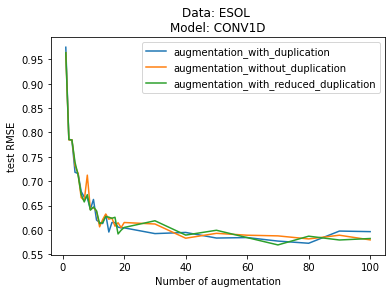

In [24]:
plot_single("rmse", "test", full_grid, "ESOL", "CONV1D")

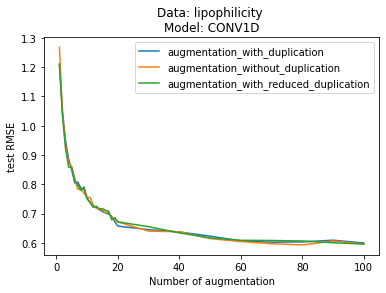

In [25]:
plot_single("rmse", "test", full_grid, "lipophilicity", "CONV1D")

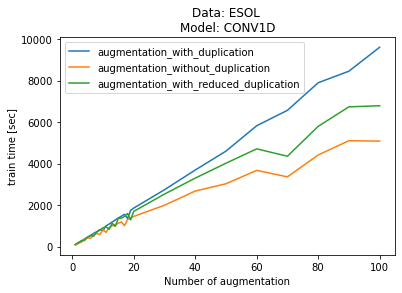

In [26]:
plot_single("time", "train", full_grid, "ESOL", "CONV1D")

## Load results for EGFR

### Canonical model

In [27]:
test_r2_canonical = retrieve_metric("r2",
                                    "test",
                                    "affinity",
                                    "no_augmentation",
                                    0,
                                    "no_augmentation",
                                    0,
                                    "CONV1D")
test_rmse_canonical = retrieve_metric("rmse",
                                      "test",
                                      "affinity",
                                      "no_augmentation",
                                      0,
                                      "no_augmentation",
                                      0,
                                      "CONV1D")
print(f"{test_r2_canonical = :.3f}, {test_rmse_canonical = :.3f}")

test_r2_canonical = 0.494, test_rmse_canonical = 1.031


### Maxsmi model

In [28]:
test_r2_maxsmi = retrieve_metric("r2",
                                 "test",
                                 "affinity",
                                 "augmentation_with_reduced_duplication",
                                 70,
                                 "augmentation_with_reduced_duplication",
                                 70,
                                 "CONV1D")
test_rmse_maxsmi = retrieve_metric("rmse",
                                   "test",
                                   "affinity",
                                   "augmentation_with_reduced_duplication",
                                   70,
                                   "augmentation_with_reduced_duplication",
                                   70,
                                   "CONV1D")
print(f"{test_r2_maxsmi = :.3f}, {test_rmse_maxsmi = :.3f}")

test_r2_maxsmi = 0.712, test_rmse_maxsmi = 0.777
